#Model evaluation - Static

Connect to Google Drive, load libraries, reference

In [ ]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/MyDrive/CSC8635/

## set up the libraries that are needed to run the analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import itertools
import re, time
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils

from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
#print("Number of accelerators: ", strategy.num_replicas_in_sync)

#Based on code: https://www.kaggle.com/teaprint/my-analysis-on-motion-sensor-data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/MyDrive/CSC8635
Tensorflow version 2.7.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Load data

In [ ]:
#@title
#set up for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf

import os
#print(os.listdir("A_DeviceMotion_data/A_DeviceMotion_data"))

# Data Folders:
Folders = glob('A_DeviceMotion_data/A_DeviceMotion_data/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 samples frames , each one will be a different experiment
Segment_Size = 400

# Activity types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
  Csv = glob(j + '/*' )
  for i in Csv:
    df = pd.read_csv(i)
    df['Activity'] = activity_codes[j[40:43]]
    df['Sub_Num'] = i[len(j)+5:-4]
    df['Exp_num'] = 1
    ExpNum = np.zeros((df.shape[0])) 
    for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
      ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
    df['Exp_num'] = ExpNum
    #Df_all = pd.concat([Df_all,df])
    Df_all_list.append(df)
    Exp += 1        
Df_all = pd.concat(Df_all_list,axis=0)  
print(f'The data has been loaded.')
print(f'The dimensions of the complete dataset are {Df_all.shape}.')
print(f'The 16 column headers are {Df_all.columns}.')
#check unique values for the participants
#np.unique(Df_all['Sub_Num'])

The data has been loaded.
The dimensions of the complete dataset are (1412865, 16).
The 16 column headers are Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object').


Select standing and sitting activity types (645205 rows of data)

In [ ]:
#@title
Static = Df_all.loc[(Df_all['Activity'] == 4)
                     | (Df_all['Activity'] == 3)]

In [ ]:
#@title
X = Static.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Y = Static['Sub_Num']
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (645205, 12)
Shape of Y: (645205,)


###**Trial Participant**

Split data into train and test

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

Scale data

In [ ]:
#@title
#scale the data

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train and test model

In [ ]:
#@title
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic_regression (L1) - accuracy: 0.56, f1 score: 0.53, total_time: 84.57 sec


In [ ]:
#@title
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic_regression (L2) - accuracy: 0.56, f1 score: 0.53, total_time: 82.83 sec


In [ ]:
#@title
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.99, f1 score: 0.99, total_time: 33.78 sec


Decision tree accuracy: 0.9905714964714148


<Figure size 432x288 with 0 Axes>

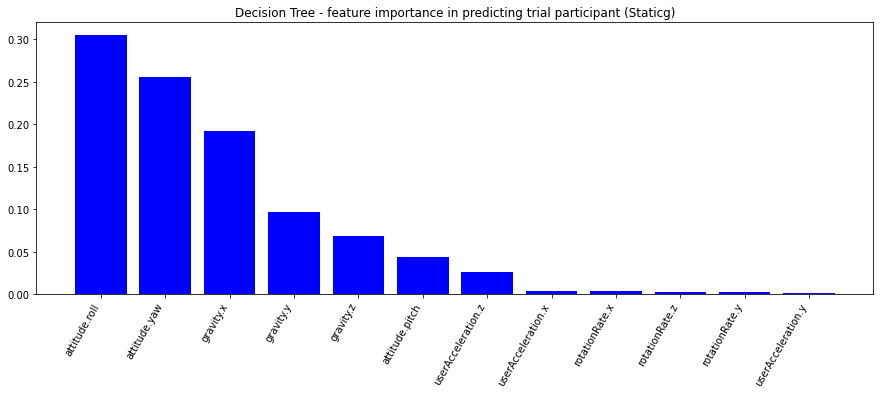

In [ ]:
#@title
feature_names = X.columns
X_names = feature_names

# for tree-based classifier's feature importance plotting
def plot_keyFeat_trees(classifier, feature_names, clf_id, top_features=10):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices_vis = indices[:top_features]
    
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    plt.bar(range(top_features), importances[indices_vis],
       color="b", align="center")
    plt.xticks(range(top_features), indices)
    plt.xlim([-1, top_features])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[indices_vis], rotation=60, ha='right')
    plt.show()

print('Decision tree accuracy:',accuracy_score(Y_test, DT.predict(X_test)))
plot_keyFeat_trees(DT, X_names, 'Decision Tree - feature importance in predicting trial participant (Staticg)', top_features=12)

In [ ]:
#@title
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))


K- Nearest Neighbour  - accuracy: 0.95, f1 score: 0.95, total_time: 200.67 sec


###**Gender**

Mapping for gender (1 for male, 0 for female)

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':1,
    '22':1,
    '23':0,
    '24':0

}

In [ ]:
#@title
# Create gender labels
Y2 = [mapping[i] for i in Static['Sub_Num']]

Prepare training and test data sets, apply scaling

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train and test models, print evaluation results

In [ ]:
#@title
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.63, f1 score: 0.61, total_time: 1.94 sec


In [ ]:
#@title
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.63, f1 score: 0.61, total_time: 1.87 sec


In [ ]:
#@title
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 1.00, f1 score: 1.00, total_time: 13.41 sec


In [ ]:
#@title
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.98, f1 score: 0.98, total_time: 231.73 sec


Show results of model performance by gender identification

###**Weight**

Mapping - above the average weight 72.125kg are labeled as 1; 0 for below average.

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':0,
    '12':0,
    '13':0,
    '14':0,
    '15':0,
    '16':1,
    '17':1,
    '18':0,
    '19':1,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':1

}

In [ ]:
#@title
# Create weight labels
Y3 = [mapping[i] for i in Static['Sub_Num']]

Split training and test data, scale data

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y3, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Evaluate model performance

In [ ]:
#@title
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.59, f1 score: 0.54, total_time: 1.85 sec


In [ ]:
#@title
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.59, f1 score: 0.54, total_time: 1.80 sec


In [ ]:
#@title
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.99, f1 score: 0.99, total_time: 15.80 sec


In [ ]:
#@title
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.98, f1 score: 0.98, total_time: 229.91 sec


###**Age**

Mapping - subjects above the average age of 28.79 are labeled as 1; 0 for below average

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':0,
    '7':1,
    '8':0,
    '9':1,
    '10':1,
    '11':0,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':1,
    '17':0,
    '18':0,
    '19':0,
    '20':0,
    '21':0,
    '22':1,
    '23':0,
    '24':0

}


In [ ]:
#@title
# Create age labels
Y4 = [mapping[i] for i in Static['Sub_Num']]

Split data into training and test, then scale

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y4, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Evaluate models

In [ ]:
#@title
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.66, f1 score: 0.65, total_time: 1.87 sec


In [ ]:
#@title
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.66, f1 score: 0.65, total_time: 1.88 sec


In [ ]:
#@title
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.99, f1 score: 0.99, total_time: 15.94 sec


In [ ]:
#@title
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.97, f1 score: 0.97, total_time: 242.39 sec


###**Height**

Mapping - the trail participants with above average height of 174.2cm are labeled as 1; 0 for below average

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':1,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':0,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':0

}


In [ ]:
#@title
# Create age labels
Y5 = [mapping[i] for i in Static['Sub_Num']]

Split training and test data, then scale data

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y5, test_size=0.3, random_state=0)

Evaluate model performance

In [ ]:
#@title
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic_regression (L1) - accuracy: 0.62, f1 score: 0.61, total_time: 8.50 sec


In [ ]:
#@title
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic_regression (L2) - accuracy: 0.62, f1 score: 0.61, total_time: 8.52 sec


In [ ]:
#@title
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 1.00, f1 score: 1.00, total_time: 14.45 sec


In [ ]:
#@title
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 1.00, f1 score: 1.00, total_time: 52.29 sec


##**Summary**

Performance of the models varied significantly with the Decision Tree Classification Model having the highest accuracy for each variable. Time to compute also varied vastly, with the Logistic Regression Models completing fastest but having lowest accuracy. Models ranged in accuracy of predicting gender 63% to 100%, height 62% to 100%, age 66% to 99% and weight from 59% to 99% accuracy.
